<a href="https://colab.research.google.com/github/Fredooooooo/JSC270_Assg4/blob/main/JSC270_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
api_key = 'RnHS3Y3lkrv9pzkHVFcVYVArH'
api_secret_key = 'xLMxTxhEHluPlcsPgb2rur07hBR4qSuzGdIVhJg0hpEiR1nTBm'
access_key = '1376070608950267904-AlJkcNLLxsAByp9NmFU854synmuzq5'
access_secret = 'dtH18I0v8Ob44BAUXhrJB9TNvnFfQykBafXY4fl4JtdJB'

In [3]:
import re
import numpy as np
import pandas as pd 
import io
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve
import matplotlib.pyplot as plt

In [9]:
import tweepy as tw
# Use credentials to authorize access
auth = tw.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth, wait_on_rate_limit=True)
search_words = ' -filter:retweets'
date_since = "2021-03-09"

#Collect tweets (here, I get only 20)
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(200)

# The result is an iterable
a = []
b = []
for tweet in tweets:
  a.append(tweet.text)
  b.append(tweet.user.followers_count)

In [10]:
import pandas as pd
import re

# tweet_list = [tweet.text for tweet in tweets]
df = pd.DataFrame(a, columns = ['tweet'])
df['followers'] = b
print(df.count())

tweet        200
followers    200
dtype: int64


In [24]:
handle_regex = '@[A-Za-z|0-9|_]+'

d = []
for row in df['tweet']:
  d.append(re.sub(handle_regex,'', row))

df['tweet'] = d
df.head()

,tweet,followers,labels,tokens
0,Do the #Braves just not care about winning any...,8979,1,"[brave, just, not, care, about, winning, anymo..."
1,a special gift for all coin hod1ers out there...,440,1,"[special, gift, all, coin, hod1ers, out, there..."
2,being ate UP😭,1698,1,"[ate, up]"
3,"The day I lose you, I will lose myself.",0,0,"[day, lose, will, lose]"
4,That dumb shit. The youth they know no better.,159,1,"[dumb, shit, youth, know, no, better]"


In [25]:
c = []
for x in df['followers']:
  if 0 <= x <= 100:
    c.append(0)
  elif 100 < x <= 10000:
    c.append(1)
  else:
    c.append(2)
df['labels'] = c
df.head()

,tweet,followers,labels,tokens
0,Do the #Braves just not care about winning any...,8979,1,"[brave, just, not, care, about, winning, anymo..."
1,a special gift for all coin hod1ers out there...,440,1,"[special, gift, all, coin, hod1ers, out, there..."
2,being ate UP😭,1698,1,"[ate, up]"
3,"The day I lose you, I will lose myself.",0,0,"[day, lose, will, lose]"
4,That dumb shit. The youth they know no better.,159,1,"[dumb, shit, youth, know, no, better]"


In [26]:
low_proportion = df['labels'].tolist().count(0)
medium_proportion = df['labels'].tolist().count(1)
high_proportion = df['labels'].tolist().count(2)
print(low_proportion, medium_proportion, high_proportion)
print(df.followers.mean)

52 138 10
<bound method Series.mean of 0       8979
1        440
2       1698
3          0
4        159
       ...  
195    20783
196       33
197      449
198      187
199      789
Name: followers, Length: 200, dtype: int64>


In [27]:
import nltk
# Download the tokenizer
nltk.download('punkt')

# Create a new column in our DF that contains token lists instead of raw text
df['tokens'] = df['tweet'].apply(nltk.word_tokenize)

print(df['tokens'].head(5))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0    [Do, the, #, Braves, just, not, care, about, w...
1    [a, special, gift, for, all, coin, hod1ers, ou...
2                                    [being, ate, UP😭]
3    [The, day, I, lose, you, ,, I, will, lose, mys...
4    [That, dumb, shit, ., The, youth, they, know, ...
Name: tokens, dtype: object


In [28]:
##### Convert tokens into lowercase ####
lowercase_tokens = []
# Create a list of lists with what we want
for row in df['tokens']:
  lowercase_tokens.append([t.lower() for t in row])
# add the new info to our df
df['lowercase_tokens'] = lowercase_tokens

print(df['lowercase_tokens'].head(5))

0    [do, the, #, braves, just, not, care, about, w...
1    [a, special, gift, for, all, coin, hod1ers, ou...
2                                    [being, ate, up😭]
3    [the, day, i, lose, you, ,, i, will, lose, mys...
4    [that, dumb, shit, ., the, youth, they, know, ...
Name: lowercase_tokens, dtype: object


In [29]:
##### Let's remove punctuation #####

# Note we've been keeping different columns for different steps (not necessary)
list(df)

# Same process as before
tokens_no_punct = []
# Create a list of lists with what we want
for row in df['lowercase_tokens']:
  tokens_no_punct.append([re.sub('[^\w\s]','', t) for t in row])
# add the new info to our df
df['tokens_no_punct'] = tokens_no_punct

print(df['tokens_no_punct'].head(5))

0    [do, the, , braves, just, not, care, about, wi...
1    [a, special, gift, for, all, coin, hod1ers, ou...
2                                     [being, ate, up]
3    [the, day, i, lose, you, , i, will, lose, myse...
4    [that, dumb, shit, , the, youth, they, know, n...
Name: tokens_no_punct, dtype: object


In [31]:
##### Time to remove Stopwords #####
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')[:75]
tokens_no_sw = []
for row in df['tokens_no_punct']:
  tokens_no_sw.append([w for w in row if w not in sw])
# Add column to df
df['tokens_no_sw'] = tokens_no_sw

# Print some examples
print(df['tokens_no_sw'].head(5))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0    [, braves, just, not, care, about, winning, an...
1    [special, gift, all, coin, hod1ers, out, there...
2                                            [ate, up]
3                          [day, lose, , will, lose, ]
4            [dumb, shit, , youth, know, no, better, ]
Name: tokens_no_sw, dtype: object


In [32]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmed_tokens = []
for row in df['tokens_no_sw']:
  stemmed_tokens.append([stemmer.stem(t) for t in row])

df['stemmed_tokens'] = stemmed_tokens
print('Before stemming:\n', df['tokens_no_sw'].head(3))
print('After stemming:\n', df['stemmed_tokens'].head(3))

Before stemming:
 0    [, braves, just, not, care, about, winning, an...
1    [special, gift, all, coin, hod1ers, out, there...
2                                            [ate, up]
Name: tokens_no_sw, dtype: object
After stemming:
 0    [, brave, just, not, care, about, win, anymor,...
1    [special, gift, all, coin, hod1er, out, there,...
2                                            [ate, up]
Name: stemmed_tokens, dtype: object


In [33]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
lem_tokens = []
for row in df['tokens_no_sw']:
  lem_tokens.append([lemmatizer.lemmatize(t) for t in row])

df['lem_tokens'] = lem_tokens

# Print results
print(df['lem_tokens'].head(5))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
0    [, brave, just, not, care, about, winning, any...
1    [special, gift, all, coin, hod1ers, out, there...
2                                            [ate, up]
3                          [day, lose, , will, lose, ]
4            [dumb, shit, , youth, know, no, better, ]
Name: lem_tokens, dtype: object


In [34]:
# Drop some intermediate columns
list(df)
df = df.drop(['tokens','lowercase_tokens', 'tokens_no_punct','tokens_no_sw','stemmed_tokens'], axis = 1)

print('After removal:\n', list(df))

# Remove blank tokens
no_blanks = []
for row in df['lem_tokens']:
  no_blanks.append([t for t in row if t != ''])
df['tokens'] = no_blanks

print(df['tokens'].head(5))

# drop the last intermediate column
df = df.drop(['lem_tokens'], axis = 1)

# Now we should have only the label, original text, and cleaned token lists
print('Current Columns:\n',list(df))

After removal:
 ['tweet', 'followers', 'labels', 'lem_tokens']
0    [brave, just, not, care, about, winning, anymo...
1    [special, gift, all, coin, hod1ers, out, there...
2                                            [ate, up]
3                              [day, lose, will, lose]
4                [dumb, shit, youth, know, no, better]
Name: tokens, dtype: object
Current Columns:
 ['tweet', 'followers', 'labels', 'tokens']


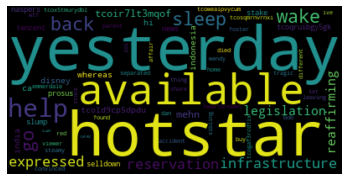

In [42]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
popular = df['labels'] > 1
df_pop = df[popular]
text = []
for lst in df_pop['tokens']:
  text.extend(lst)
text = ' '.join(text)
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

# Separate labels from features, converting to numpy arrays
X, y = df['tokens'].to_numpy(), df['labels'].to_numpy()


def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None)

# Remember this output is a Scipy Sparse Array
counts = count_vec.fit_transform(X)
print(counts.toarray())

# Print the names of each of the features (1000 total))
print(count_vec.get_feature_names())
# Print this mapping as dictionary
print(count_vec.vocabulary_)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['1', '12', '15', '1991', '2010s', '2021', '205a', '23april2017', '3', '40', '5', '7', '9', '9toeternitywithexo', '9years', '9yearswithexo', 'aaa', 'about', 'above', 'accident', 'account', 'actual', 'actually', 'ada', 'addie', 'adding', 'af', 'affair', 'after', 'again', 'against', 'agree', 'ahhhhhhh', 'aired', 'all', 'already', 'also', 'always', 'amp', 'android', 'anime', 'another', 'answer', 'any', 'anymore', 'anyone', 'anyway', 'app', 'appear', 'area', 'arianagrande', 'around', 'article', 'artist', 'artpop', 'as', 'asap', 'asked', 'assuming', 'ate', 'audit', 'available', 'aw', 'award', 'aww', 'babe', 'babyyy', 'back', 'bad', 'banger', 'bark', 'base', 'based', 'bash', 'bc', 'bear', 'bed', 'beef', 'beep', 'beer', 'before', 'best', 'bestfanarmy', 'bestie', 'bestlyrics', 'bestmusicvideo', 'better', 'between', 'bihar', 'birthday', 'bitch', 'black', 'bless', 'bob', 'body'

In [36]:
#### TF-IDF Vectorize ####

# Note that smoothing is done by default
tfidf = TfidfTransformer()

tfs = tfidf.fit_transform(counts)

# Let's use the TFIDF counts for modelling
X = tfs.toarray()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# First three rows of training features and labels

Test accuracy with simple Naive Bayes: 0.725


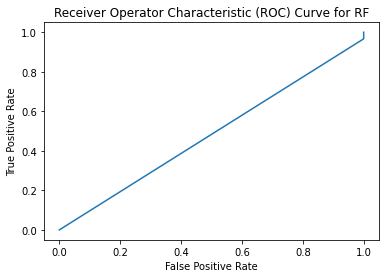

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve
import matplotlib.pyplot as plt

# Let's fit the Naive Bayes model to our training data
nb = MultinomialNB()
# Fit model to training data
nb.fit(X_train, y_train)
# Predict on test data
y_preds = nb.predict(X_test)

print('Test accuracy with simple Naive Bayes:',accuracy_score(y_test,y_preds))

fpr, tpr, thresholds = roc_curve(y_test, y_preds, pos_label = 1)

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic (ROC) Curve for RF')
plt.show()